In [39]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import json
from pqdm.processes import pqdm
import warnings
from scipy import stats
from types import SimpleNamespace

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

# Reperesentativeness

In [40]:
pre_homes = pd.read_parquet(P.data + '/Ida_home.parquet').dropna()

In [41]:
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')

<Axes: >

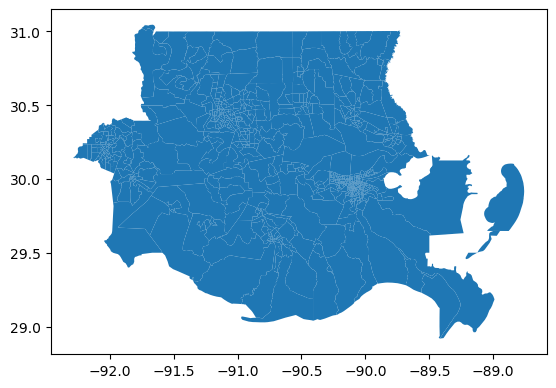

In [42]:
svi_tract.plot()

## County level

In [43]:
acs_cnty = gpd.GeoDataFrame(svi_tract.groupby('county')
               .agg({'e_totpop': np.sum, 'geometry': lambda x: x.unary_union})
               .reset_index()).set_crs(CRS_DEG)

C:\Users\ALei\AppData\Local\Temp\ipykernel_32072\338672797.py:2: FutureWarning: The provided callable <function sum at 0x000001E90ABBFF40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  .agg({'e_totpop': np.sum, 'geometry': lambda x: x.unary_union})


In [95]:
297082/2935867

0.10119055120684962

In [94]:
np.sum(rpr_cnty['e_totpop'])

2935867

In [44]:
pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG).dropna()
rpr_cnty = (acs_cnty[['county', 'e_totpop', 'geometry']].query('e_totpop > 0')
           .merge(gpd.sjoin(pre_homes,
                            acs_cnty[['county', 'geometry']], predicate='within'), on='county')
                  .groupby(['county','e_totpop']).size().rename('n_users').reset_index()).assign(repres = lambda df: df['n_users'] / df['e_totpop'] * 100)

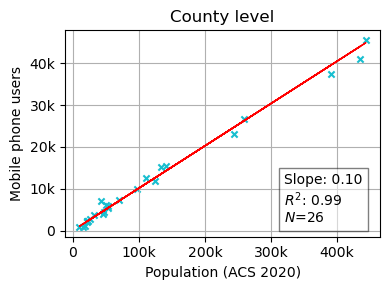

In [46]:
series1 = rpr_cnty['e_totpop']
series2 = rpr_cnty['n_users']

# For a line with zero intercept, slope equals the ratio of the two series
slope = series2.mean() / series1.mean()
intercept = 0  # we want line with zero intercept

# Calculate the predicted values
predicted_values = intercept + slope * series1

# Calculate R-squared value
r_squared = stats.pearsonr(series1, series2)[0] ** 2

fig, ax = plt.subplots(1,1, figsize = (4,3))

# Create a scatter plot of the original data
plt.scatter(series1, series2, marker = 'x', s = 20, color = 'C9')

# Create a line plot of the predicted values
plt.plot(series1, predicted_values, color='red', linewidth = 1)

plt.xlabel('Population (ACS 2020)')
plt.ylabel('Mobile phone users')
plt.title('County level')
plt.text(320000,2000,'Slope: {0:.2f}\n$R^2$: {1:.2f} \n$N$={2:.0f}'.format(slope, r_squared, len(series1)), bbox=dict(facecolor='white', alpha=0.5))

ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k'])

ax.set_xticks([0, 100000, 200000, 300000, 400000])
ax.set_xticklabels(['0', '100k', '200k', '300k', '400k'])

plt.grid(visible = True)
plt.tight_layout()

plt.savefig('../figs/repre_county.pdf')
plt.savefig('../figs/repre_county.png', dpi=300)

# Census Tract level

In [47]:
pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG).dropna()
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')

rpr_tract = (svi_tract[['geoid', 'e_totpop', 'geometry']].query('e_totpop > 0')
           .merge(gpd.sjoin(pre_homes,
                            svi_tract[['geoid', 'geometry']], predicate='within')
                  .groupby('geoid').size().rename('n_users').reset_index(), on = 'geoid')
           .assign(repres = lambda df: df['n_users'] / df['e_totpop'] * 100))

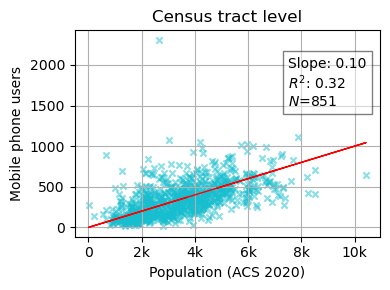

In [49]:
series1 = rpr_tract['e_totpop']
series2 = rpr_tract['n_users']

# For a line with zero intercept, slope equals the ratio of the two series
slope = series2.mean() / series1.mean()
intercept = 0  # we want line with zero intercept

# Calculate the predicted values
predicted_values = intercept + slope * series1

# Calculate R-squared value
r_squared = stats.pearsonr(series1, series2)[0] ** 2

fig, ax = plt.subplots(1,1, figsize = (4,3))

# Create a scatter plot of the original data
plt.scatter(series1, series2, marker = 'x', s = 20, color = 'C9', alpha = 0.5)

# Create a line plot of the predicted values
plt.plot(series1, predicted_values, color='red', linewidth = 1)

plt.xlabel('Population (ACS 2020)')
plt.ylabel('Mobile phone users')
plt.title('Census tract level')
plt.text(7500,1500,'Slope: {0:.2f}\n$R^2$: {1:.2f} \n$N$={2:.0f}'.format(slope, r_squared, len(series1)), bbox=dict(facecolor='white', alpha=0.5))

ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
ax.set_xticklabels(['0', '2k', '4k', '6k', '8k', '10k'])

plt.grid(visible = True)
plt.tight_layout()

plt.savefig('../figs/repre_tract.pdf')
plt.savefig('../figs/repre_tract.png', dpi=300)

# Merged Tract

830


<Axes: >

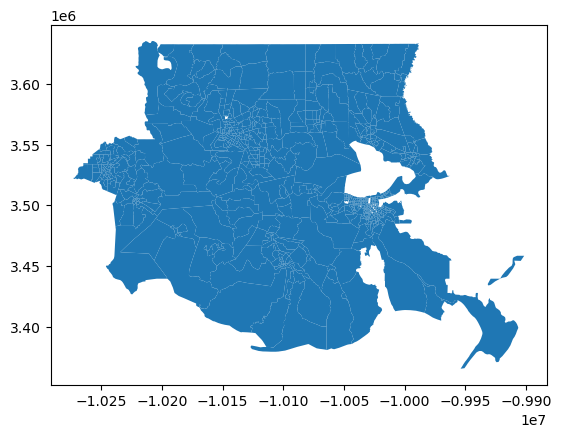

In [84]:
import itertools

from shapely.ops import unary_union

# Function to compute the combined 'repres' of a list of tracts
def compute_repres_pop(tracts):
    total_pop = sum(tract[1]['e_totpop'] for tract in tracts.iterrows())
    total_users = sum(tract[1]['n_users'] for tract in tracts.iterrows())
    return total_users / total_pop * 100 if total_pop > 0 else 0, total_pop

# Function to merge a list of tracts
def merge_tracts(tracts):
    merged = {}
    merged['geoids'] = sum([tract[1]['geoids'] for tract in tracts.iterrows()], [])
    merged['geometry'] = unary_union([tract[1]['geometry'] for tract in tracts.iterrows()])
    merged['e_totpop'] = sum(tract[1]['e_totpop'] for tract in tracts.iterrows())
    merged['n_users'] = sum(tract[1]['n_users'] for tract in tracts.iterrows())
    merged['area'] = sum(tract[1]['area'] for tract in tracts.iterrows())
    merged['repres'] = compute_repres_pop(tracts)[0]
    merged['geometry_buffered'] = merged['geometry'].buffer(100)
    return merged

pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG).dropna()
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')

rpr_tract = (svi_tract[['geoid', 'e_totpop', 'geometry']].query('e_totpop > 0')
           .merge(gpd.sjoin(pre_homes,
                            svi_tract[['geoid', 'geometry']], predicate='within')
                  .groupby('geoid').size().rename('n_users').reset_index(), on = 'geoid')
           .assign(repres = lambda df: df['n_users'] / df['e_totpop'] * 100))

rpr_tract['geoids'] = rpr_tract['geoid'].apply(lambda x: [x])
rpr_tract = rpr_tract.assign(area = rpr_tract['geometry'].to_crs(CRS_M).area)

# get the area
rpr_tract = rpr_tract[(rpr_tract['e_totpop']>1000)].reset_index(drop = True)
rpr_tract = rpr_tract.to_crs(CRS_M)
print(len(rpr_tract))
rpr_tract.plot()

In [85]:
# For each low-repres tract, find a combination of neighboring tracts to merge with that
# results in a 'repres' value of over 5%

max_iter = 5000
flag = True
iter_ = 0

rpr_tract['geometry_buffered'] = rpr_tract.geometry.buffer(100)

while flag:
    flag = False
    if iter_ == max_iter:
        print("max iter reached, some zones are isolated and cannot be merged to satisfy the requirement")
        break
    
    # update low-repres tracts
    low_repres_tracts = rpr_tract[(rpr_tract['n_users'] < 400) | (rpr_tract['area'] < 2589988 * 4)].copy()

    low_repres_tracts = low_repres_tracts.sort_values(by = 'area') # from small to large
    
    for idx, tract in low_repres_tracts.iterrows():
        # make it touch within a buffer, say 1oo m
        buffered_geometry = tract['geometry_buffered']
        
        neighbors = rpr_tract[rpr_tract.geometry.intersects(buffered_geometry)] 
        
        # sort by area from small to large
        neighbors = neighbors.sort_values(by = 'area')
        for combination in neighbors.index:
            if combination == idx: # skip itself
                # print("WOW")
                continue
            combination = [combination] + [idx]  # Include the current tract
            combined_repres, combined_pop = compute_repres_pop(rpr_tract.loc[combination])
            if combined_pop > 30000: # avoid to large populated area
                continue
            if (combined_repres >= 5):
                merged_tract = pd.DataFrame(data = [merge_tracts(rpr_tract.loc[combination])], index = None)
                # Replace the existing tracts with the merged tract
                rpr_tract = rpr_tract.drop(combination)
                rpr_tract = pd.concat([rpr_tract, merged_tract], ignore_index=True)
                flag = True
                break  # Move on to the next low-repres tract
        if flag:
            break

    iter_ += 1

In [86]:
rpr_tract = rpr_tract[(rpr_tract['area']>=2589988 * 4) & (rpr_tract['n_users'] >= 400) & (rpr_tract['repres'] >= 5)]
rpr_tract['id'] = rpr_tract.index
rpr_tract.drop('geoid', axis = 1, inplace = True)
len(rpr_tract)

282

In [87]:
rpr_tract.drop('geometry_buffered', axis = 1, inplace = True)
rpr_tract.to_parquet(P.data + '/map/all_merged_tract.parquet')

In [88]:
rpr_tract = gpd.read_parquet(P.data + '/map/all_merged_tract.parquet')
import contextily as ctx

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


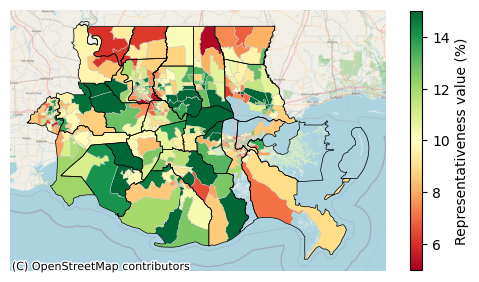

In [89]:
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')

fig, ax = plt.subplots(1,1, figsize = (5,4))

plt.axis('off')

# plt.title('Representativeness at merged census tract level\n(Pre-disaster: 8/1 - 8/21)')

rpr_tract.set_crs(CRS_M).plot(
    ax=ax, column='repres', cmap='RdYlGn', legend=True, 
    vmin=5, vmax=15, linewidth=0.3, edgecolor='#ccc',
    legend_kwds=dict(shrink=0.7, label='Representativeness value (%)'))

# add background map using contextily
(gpd.GeoDataFrame(svi_tract.groupby('county')['geometry'].apply(lambda x: x.unary_union)
     .reset_index()).set_crs(CRS_DEG).to_crs(CRS_M)
 .plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5))

ctx.add_basemap(ax, crs = CRS_M, source=ctx.providers.OpenStreetMap.Mapnik)


plt.tight_layout()
plt.savefig('../figs/repre_spatial_merged_tract.pdf')
plt.savefig('../figs/repre_spatial_merged_tract.png', dpi=300)

In [90]:
# Source of errors:

# 1. The home detection data has error of range up to several, with census tract smaller than 1 square mile, this error contribute to a lot of noise
# 2. Some tracts has low population, and the representativeness is not stable
# 3. Some tracts has low number of users in GPS data, and the representativeness is not stable

In [91]:
rpr_tract[['id','geometry']].set_crs(CRS_M).to_crs(CRS_DEG).to_file(P.data + "/map/merged_tract.gpkg")
rpr_tract[['id', 'geoids', 'n_users', 'e_totpop', 'repres']].to_parquet(P.data + "/repres_by_merged_tract.parquet")

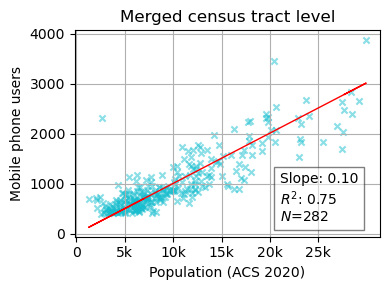

In [93]:
series1 = rpr_tract['e_totpop']
series2 = rpr_tract['n_users']

# For a line with zero intercept, slope equals the ratio of the two series
slope = series2.mean() / series1.mean()
intercept = 0  # we want line with zero intercept

# Calculate the predicted values
predicted_values = intercept + slope * series1

# Calculate R-squared value
r_squared = stats.pearsonr(series1, series2)[0] ** 2

fig, ax = plt.subplots(1,1, figsize = (4,3))

# Create a scatter plot of the original data
plt.scatter(series1, series2, marker = 'x', s = 20, color = 'C9', alpha = 0.5)

# Create a line plot of the predicted values
plt.plot(series1, predicted_values, color='red', linewidth = 1)

plt.xlabel('Population (ACS 2020)')
plt.ylabel('Mobile phone users')
plt.title('Merged census tract level')
plt.text(21000, 250,'Slope: {0:.2f}\n$R^2$: {1:.2f} \n$N$={2:.0f}'.format(slope, r_squared, len(series1)), bbox=dict(facecolor='white', alpha=0.5))

ax.set_xticks([0, 5000, 10000, 15000, 20000, 25000])
ax.set_xticklabels(['0', '5k', '10k', '15k', '20k', '25k'])

# ax.set_yticks([0, 500, 1000, 1500])
# ax.set_yticklabels(['0', '500', '1k', '1.5k'])

# ax.set_ylim([0,860])

plt.grid(visible = True)
plt.tight_layout()

plt.savefig('../figs/repre_merged_tract.pdf')
plt.savefig('../figs/repre_merged_tract.png', dpi=300)




































# Recover merged_tract from repres_by_merged_tract

This is needed when someone reruns the code and saves a new version of merged_tract and repres_by_merged_tract. Then df_input needs to be redo unless you can recover the old merged_tract from repres_by_merged_tract.

In [124]:
from shapely.ops import unary_union

merged_tract_ = pd.read_parquet(P.data + '/repres_by_merged_tract.parquet')
merged_tract_.head()
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')
svi_tract = svi_tract[['geoid','geometry']]
svi_tract['geoid'] = svi_tract['geoid'].astype(np.int64)

def merge_tracts(tracts):
    merged = {}
    merged['geoids'] = sum([[tract['geoid']] for _,tract in tracts.iterrows()], [])
    merged['geometry'] = unary_union([tract['geometry'] for _,tract in tracts.iterrows()])
    return merged

res = []

for idx, tract in merged_tract_.iterrows():
    neighbors = tract['geoids']
    combination = list(neighbors) # Include the current tract
    merged_tract = merge_tracts(svi_tract[svi_tract['geoid'].isin(combination)])
    res.append(merged_tract)

merged_tract = gpd.GeoDataFrame(res).set_crs('wgs84')
merged_tract['id'] = merged_tract.index
merged_tract.drop("geoids", axis = 1, inplace = True)
merged_tract.to_file(P.data + "/map/merged_tract.gpkg")